In [1]:
### fix how M values is taken in
### Switch to Jupyter Notebook
### Import Data
### Make a special data file with only 10 events or so
### Plot the raw signals from those 10 events
### Plot resulting Trapezoids
# figure out calibration
# Plot the full, calibrated energy spectra for Co, Cs, Am (to check for re-takes)
# Fit peaks and get FWHM Values
# Plot FWHM vs gap time
# Plot FWHM vs peak time
# Set optimal peak and gap times and save spectrum
# Make electronic noise plot
# calculate FANO factor
# Write text
# Write TEST functions
# BASELINE CORREXTION #np.mean(data['Rawdata']) np apply along axis 0 =comuln, 1 = row
# REDO DATA Cs = low stats, Co maybe okay, Am/ Co peaks?/ pulser?

#BASELINE CORREXTION #np.mean(data['Rawdata']) np apply along axis 0 = comuln, 1 = row, reshape?
#def fast_baseline_correction(data):


In [2]:
from __future__ import division, print_function
from numba import jit
from math import floor
import matplotlib.pyplot as plt
import numpy as np
import lmfit
import tables
import sys
import csv
import time

In [32]:
@jit(parallel = True)
def baseline_correction(data):
    n_data = len(data)
    baseline_correction_value = np.mean(data[0:799])
    for i in range(0, n_data, 1):
        data[i] = data[i] - baseline_correction_value
    return data

def fast_baseline_correction(data):
    baseline = np.mean(data[:len(data),0:99],1).reshape((len(data),1))
    baseline_corrected = data[:len(data),] - baseline
    return(baseline_corrected)

def test_baseline_correction():
    data = []
    for i in range(0, 800, 1): # TODO NOT WORKING
        data.append(100)
    for i in range(800, 810, 1):
        data.append(500)
    data = baseline_correction(data)
    assert data[10] == 0

def pz_correction(data, tau):
    pz_corrected = []
    pz_correction = []
    for i in range(0, n_data, 1):
        pz = np.sum(data[1:i-1])
        pz_correction.append(pz)
        pz_corrected.append(data[i] + pz / tau)
    return pz_corrected

@jit(parallel = True)
def trapezoidal_filter(signal, m, k, M):
    sum_3 = np.zeros(len(signal), dtype=np.float32)
    sum_4 = np.zeros(len(signal), dtype=np.float32)
    acc_1 = np.zeros(len(signal), dtype=np.float32)
    acc_2 = np.zeros(len(signal), dtype=np.float32)

    for i in range(2 * k + m, len(signal)):  # following block diagram in Jordanov paper
        sum1 = signal[i] - signal[i - k]
        sum2 = signal[i - k - m - k] - signal[i - k - m]
        sum_3[i] = sum1 + sum2
        acc_1[i] = sum_3[i] + acc_1[i - 1] # S(n-1) + sum3(n)
        sum_4[i] = acc_1[i] + M * sum_3[i] #PZ correction?? same?
        acc_2[i] = sum_4[i] + acc_2[i-1]
    return acc_2

@jit(parallel = True)
def get_energy_value(data):
    energy = max(data)
    return energy

@jit(parallel = True)
def trapezoidal_filter_energy(signal, m, k, M):
    sum_3 = np.zeros(len(signal), dtype=np.float32)
    sum_4 = np.zeros(len(signal), dtype=np.float32)
    acc_1 = np.zeros(len(signal), dtype=np.float32)
    acc_2 = np.zeros(len(signal), dtype=np.float32)

    for i in range(2 * k + m, len(signal)):  # following block diagram in Jordanov paper
        sum1 = signal[i] - signal[i - k]
        sum2 = signal[i - k - m - k] - signal[i - k - m]
        sum_3[i] = sum1 + sum2
        acc_1[i] = sum_3[i] + acc_1[i - 1]
        sum_4[i] = acc_1[i] + M * sum_3[i]
        acc_2[i] = sum_4[i] + acc_2[i-1]
    nrg = round(get_energy_value(acc_2), 7)
    return nrg

def fast_trapezoidal_filter(data, k, m, M=4400):
    ndata = len(data)
    l = 2*k+m
    pad = np.pad(data, (l, 0), 'constant', constant_values=(0))
    sum3 = pad[l:ndata+l] - pad[l-k-m:ndata+l-k-m] - pad[l-k:ndata+l-k] + pad[:ndata]
    acc1 = np.cumsum(sum3)
    sum4 = acc1 + sum3 * M
    acc2 = np.cumsum(sum4)
    return acc2

def fast_trapezoidal_filter_energy(data, k, m, M=4400):
    ndata = len(data)
    l = 2*k+m
    pad = np.pad(data, (l, 0), 'constant', constant_values=(0))
    sum3 = pad[l:ndata+l] - pad[l-k-m:ndata+l-k-m] - pad[l-k:ndata+l-k] + pad[:ndata]
    acc1 = np.cumsum(sum3)
    sum4 = acc1 + sum3 * M
    acc2 = np.cumsum(sum4)
    nrg = round(acc2.max(), 7)
    return nrg

def get_time_values(length_of_data, sampling_time):
    time_values = np.linspace(0, length_of_data * sampling_time, length_of_data)
    return time_values

def fit_exponential(x, y):
    exp = lmfit.models.ExponentialModel(prefix='exp_')
    pars = exp.guess(y, x=x)
    mod = exp
    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)
    return out.params

def fit_exponential_with_plot(x, y):
    exp = lmfit.models.ExponentialModel(prefix='exp_')
    pars = exp.guess(y, x=x)
    mod = exp
    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)
    print(out.fit_report())
    plt.figure()
    plt.plot(x, y, 'o')
    plt.plot(x, out.best_fit, 'r--')
    plt.show()
    return out.params

@jit(parallel=True)
def filter_and_get_energy(signal, peak, gap, M):
    signal = baseline_correction(signal)
    energy_value = fast_trapezoidal_filter_energy(signal, gap, peak, M)
    return energy_value

def fit_gaussian_with_plot(x, y):
    mod = lmfit.models.GaussianModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)
    print(out.fit_report(min_correl=0.25))
    plt.plot(x, y, 'bo')
    plt.plot(x, out.init_fit, 'k--')
    plt.plot(x, out.best_fit, 'r-')
    plt.show()
    fwhm = out.params['fwhm'].value
    center = out.params['center'].value
    return fwhm, center

def fit_gaussian(x,y):
    mod = lmfit.models.GaussianModel()
    pars = mod.guess(y, x=x)
    out  = mod.fit(y, pars, x=x)
    fwhm = out.params['fwhm'].value
    center = out.params['center'].value
    return fwhm, center
    
def import_data(filename):
    # open file
    hf = tables.open_file(filename, "r")
    event_data = hf.root.EventData.read()
    raw_data = hf.root.RawData.read()
    hf.close()

    # mask retriggered events
    mask = (event_data['retrigger'] == 1)
    raw_data[mask] = 0
    
    return raw_data

def get_bin_centers_from_edges(edges):
    edges = np.array(edges)
    centers = (edges[:-1] + edges[1:]) / 2
    return centers

def find_M_value(data, num):
    tau_values = []
    for i in range(0, num, 1):
        signal = raw_data[i,:]
        signal = baseline_correction(signal)
        x = np.asarray(range(np.argmax(signal), n_data, 1))
        y = np.asarray(signal[np.argmax(signal):n_data])
        out = fit_exponential(x, y)
        tau_values.append(out['exp_decay'].value)
    tau = np.mean(tau_values)
    return tau

In [33]:
def make_ten_event_file():
    f = open('tenevents.txt','w')
    for i in range(10):
        data = raw_data[i,:]
        for j in data:
            f.write(str(j) + ', ') 
    f.close() 
    
def read_ten_event_file():
    events = np.zeros((10, 4096))
    with open('tenevents.txt') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        i = 0
        for row in csv_reader:
            sample_count = 0
            for j in range(0, 4096, 1):
                #print(sample_count, float(row[j]))
                events[i][sample_count] = float(row[j])
                sample_count += 1
            i += 1
    return events



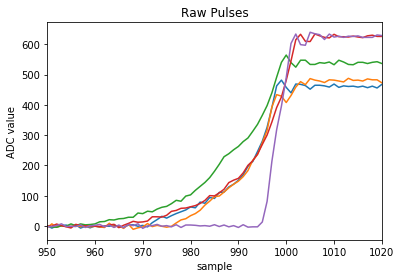

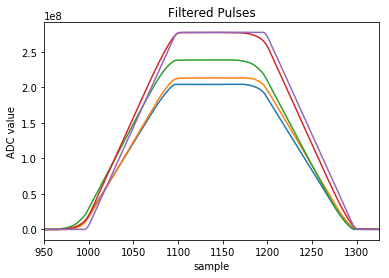

In [34]:
tenevents = read_ten_event_file()
ndata = len(tenevents)
nsamples = 4096
tenevents = fast_baseline_correction(tenevents)
for event in tenevents[0:5]:
    plt.plot(event)
plt.xlim([950, 1020])
plt.title('Raw Pulses')
plt.ylabel('ADC value')
plt.xlabel('sample')
plt.savefig('tenevents_rawdata.pdf')
plt.show()

k = 100 
m = 100 
M = 4400

#tenevents = read_ten_event_file()
#x_values = np.linspace(0, nsamples, nsamples)
#baseline = np.mean(tenevents[:ndata,0:99],1).reshape((ndata,1))
#baseline_corrected = tenevents[:ndata,] - baseline
#tenevents = np.apply_along_axis(fast_trapezoidal_filter, 1 , tenevents[:ndata,] , k, m, M)

for event in tenevents[0:5]:
    event = fast_trapezoidal_filter(event, k, m, M=4400)
    plt.plot(x_values, event)
plt.xlim([950, 1325])
plt.title('Filtered Pulses')
plt.ylabel('ADC value')
plt.xlabel('sample')
plt.savefig('tenevents_filtered.pdf')
plt.show()

import
4.93732380867
M
0.85137796402
4437.49081158
baseline
0.00137591362


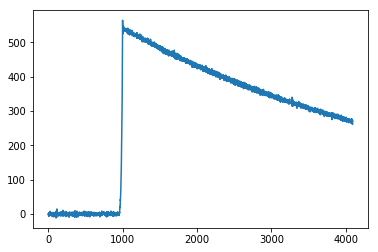

plot
0.315983057022
trap
0.000746965408325


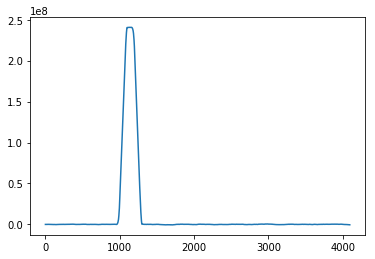

240746671.484


In [35]:
# filename = 'data/co60.h5'
start = time.time()
filename = 'data/DATA_co60_2.h5'
raw_data = import_data(filename)

end1 = time.time()
print('import')
print(end1 - start)

start = time.time()
sampling_time = 10.0
n_data = 4096
x_values = np.linspace(0, n_data, n_data)
M = find_M_value(raw_data, 10)

end1 = time.time()
print('M')
print(end1 - start)

start = time.time()
print(M)
#M = 4400
raw_signal = raw_data[2,:]
signal = baseline_correction(raw_signal)

end1 = time.time()
print('baseline')
print(end1 - start)
start = time.time()

plt.plot(signal)
plt.show()

end1 = time.time()
print('plot')
print(end1 - start)
start = time.time()

peaking_time = 100 
gap = 100 
#M = 4400
filtered_signal = fast_trapezoidal_filter(signal, gap, peaking_time, M)

end1 = time.time()
print('trap')
print(end1 - start)
start = time.time()

plt.figure(41)
plt.cla()
plt.clf()
plt.plot(x_values, filtered_signal)
plt.show()
energy = get_energy_value(filtered_signal)
print(energy)

In [36]:
nrgs = []
number_of_events = len(raw_data)
assert number_of_events <= len(raw_data)

M = find_M_value(raw_data, 10)

k = 100 # peaking time
l = 100 # gap

for i in range(0, number_of_events, 1):
    signal = raw_data[i,:]
    nrg = filter_and_get_energy(signal, l, k, M)
    nrgs.append(round(nrg, 7))

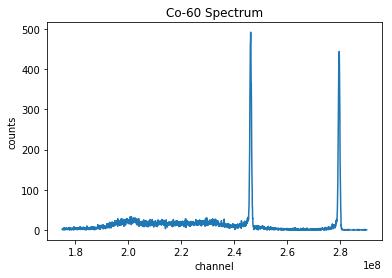

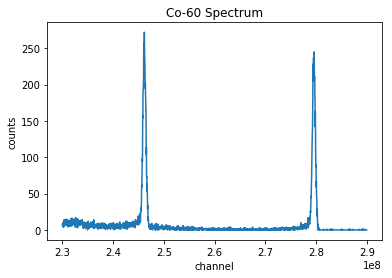

In [48]:
nbins = 2048
counts, bin_edges = np.histogram(nrgs, bins=2048, range=[1.75e8, 2.9e8]) #range=[2.3e8, 2.9e8] WORKS
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.figure()
plt.plot(bins, counts)
plt.title('Co-60 Spectrum')
plt.ylabel('counts')
plt.xlabel('channel')
plt.savefig('./co60.pdf')
plt.show()

nbins = 2048
counts, bin_edges = np.histogram(nrgs, bins=2048, range=[2.3e8, 2.9e8]) # WORKS
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.figure()
plt.plot(bins, counts)
plt.title('Co-60 Spectrum')
plt.ylabel('counts')
plt.xlabel('channel')
plt.savefig('./co60.pdf')
plt.show()


In [49]:
def find_peaks(data_x, data_y, low_index, high_index):
    cut_data_y = data_y[low_index:high_index]
    for i in range (low_index,high_index):
        if data_y[i] == max(cut_data_y):
            centerindex =  data_x[i]
            minindex=low_index
            maxindex=high_index
            amplitude = max(cut_data_y)
    ROIrange = [minindex, maxindex]
    return centerindex, amplitude, minindex, maxindex

def calculate_coefficients(calibration_channels, calibration_energies, polynomial_order):
    return np.polyfit(calibration_channels, calibration_energies, polynomial_order)

def calculate_energies(x, m, b):
    energies = m * x + b
    return energies

In [128]:
def get_energy_resolution_co_1173(x, y):
    ROI_low =0
    ROI_high = int(2048 / 2)
    fwhm, center = fit_gaussian(x[ROI_low:ROI_high], y[ROI_low:ROI_high])

    return fwhm, center

def get_energy_resolution_co_1332(x, y):
    #i = int(np.argmax(y))
    #ROI_low = int(i + 100)
    ROI_low = int(2048 / 2)
    ROI_high =  2048
    fwhm, center =  fit_gaussian(x[ROI_low:ROI_high], y[ROI_low:ROI_high])

    return fwhm, center

def calibrate_co_spectrum(nrgs):# Get first calibration point, ROI HARDCODED
    nbins = 2048
    counts, bin_edges = np.histogram(nrgs, bins=2048, range=[2.3e8, 2.9e8]) # WORKS
    bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    x = bins
    y = counts

    fwhm1, center1 = get_energy_resolution_co_1173(x, y)
    fwhm2, center2 = get_energy_resolution_co_1332(x, y)
    
    # from above fits:
    Co_energies = [1173.2, 1332.5] # MeV
    Co_indices = [center1, center2]
    print (Co_indices)
    
    f = calculate_coefficients(Co_indices, Co_energies, 1)
    print(f)
    m = f[0]
    b = f[1]
    energies = calculate_energies(x, m, b)
    
    return energies


In [129]:
co_energies = calibrate_co_spectrum(nrgs)

[240393715.49602616, 273141705.0588378]
[  4.86442075e-06   3.82382181e+00]


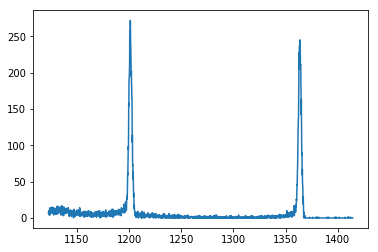

In [130]:
plt.plot(co_energies, counts)
plt.show()

In [131]:
energy_values = []
fwhm_values = []

fwhm, center = get_energy_resolution_co_1332(co_energies, counts)
fwhm_values.append(fwhm)
energy_values.append(center)

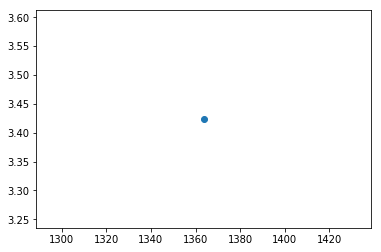

In [132]:
plt.plot(energy_values, fwhm_values, 'o')
plt.show()

In [ ]:
#k_values = np.linspace(500, 10000, 2) # steps in 100 ns from 1ns to 10us
m_values = np.linspace(2000, 100000, 2) # steps in 100 ns from 1ns to 10us
M = find_M_value(raw_data, 10)
print(M)
#M = 4400
k_values = [100]
m_values = np.linspace(0, 1000, 250) 
fwhm_values_2 = []
m_values_ns_2 = []
k = k_values[0]
for m in m_values:
    m = int(m)
    #print(m)
    m_values_ns_2.append(m * 10)
    #nrgs = []
    #ndata = len(raw_data)
    ndata = 1000
    assert number_of_events <= len(raw_data)
    x_values = np.linspace(0, nsamples, nsamples)
    baseline = np.mean(raw_data[:ndata,0:99],1).reshape((ndata,1))
    signals = raw_data[:ndata,] - baseline
    nrgs = np.apply_along_axis(fast_trapezoidal_filter, 1, signals[:ndata,] , k, m, M)
   # print(nrgs)
   # for i in range(0, number_of_events, 1):
    #    signal = raw_data[i,:]
    #    nrg = filter_and_get_energy(signal, l, k, M)
    #    nrgs.append(round(nrg, 7))
        
    nbins = 2048
    co_counts, bin_edges = np.histogram(nrgs, bins=2048, range=[2.3e8, 2.8e8]) # WORKS
    bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    #co_energies = calibrate_co_spectrum(nrgs)
    #fwhm, center = get_energy_resolution_co_1173(co_energies, co_counts)
    fwhm, center = get_energy_resolution_co_1332(co_energies, co_counts)
    fwhm_values_2.append(fwhm)

# RUNTIME = 25 seconds per m loop
# RUNTIME using FAST functions = ?? per loop

4327.31786911


In [ ]:
fwhm_percent_2 = []
for i in fwhm_values_2:
    fwhm_percent_2.append(round(i/1332.5, 7)) 

In [100]:
print(fwhm_percent_2[0:20])
print(m_values_ns_2[0:20])

[0.3810545, 0.0439896, 0.0486131, 0.0544647, 0.0566318, 0.0565016, 0.0536821, 0.0458314, 0.0254151, 0.0069511, 0.0053308, 0.0047411, 0.0044177, 0.0042153, 0.0040768, 0.0039754, 0.0038938, 0.0038313, 0.0037859, 0.003757]
[0, 40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 680, 720, 760]


[400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800, 840, 880, 920, 960, 1000, 1040, 1080, 1120, 1160]
[0.0053308, 0.0047411, 0.0044177, 0.0042153, 0.0040768, 0.0039754, 0.0038938, 0.0038313, 0.0037859, 0.003757, 0.0037457, 0.0037519, 0.0037513, 0.0037569, 0.0037608, 0.0037704, 0.0037829, 0.0037926, 0.0038009, 0.0038061]


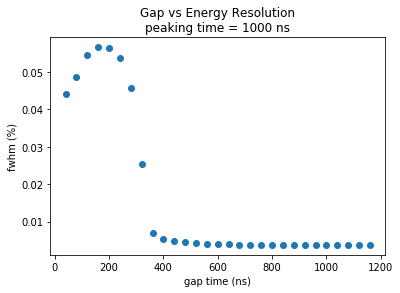

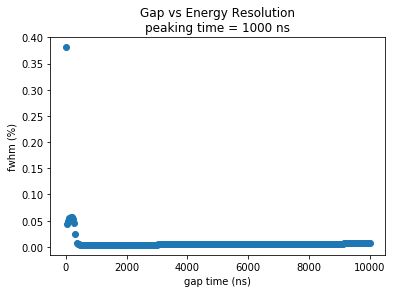

0.0037457
20
0.0037457
800


In [120]:
plt.plot(m_values_ns_2[1:30], fwhm_percent_2[1:30], 'o')
print(m_values_ns_2[10:30])
print(fwhm_percent_2[10:30])
plt.xlabel('gap time (ns)')
plt.ylabel('fwhm (%)')
plt.savefig('gap_optimization.png')
plt.title('Gap vs Energy Resolution' + '\n'  + 'peaking time = 1000 ns')
plt.show()

plt.plot(m_values_ns_2, fwhm_percent_2, 'o')
plt.xlabel('gap time (ns)')
plt.ylabel('fwhm (%)')
#plt.savefig('gap_optimization.png')
plt.title('Gap vs Energy Resolution' + '\n'  + 'peaking time = 1000 ns')
plt.show()

print(min(fwhm_percent_2))
print(np.argmin(fwhm_percent_2))
print(fwhm_percent_2[np.argmin(fwhm_percent_2)])
print(m_values_ns_2[np.argmin(fwhm_percent_2)])

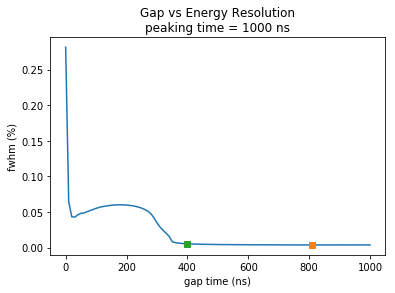

0.00375025014555
81
0.00375025014555
810


In [127]:
plt.plot(m_values_ns[0:100], fwhm_percent[0:100])
plt.plot(np.argmin(fwhm_percent) * 10, fwhm_percent[np.argmin(fwhm_percent)], 's')
plt.plot(m_values_ns[40], fwhm_percent[40], 's')
plt.xlabel('gap time (ns)')
plt.ylabel('fwhm (%)')
plt.savefig('gap_optimization_2.png')
plt.title('Gap vs Energy Resolution' + '\n'  + 'peaking time = 1000 ns')
plt.show()
print(min(fwhm_percent))
print(np.argmin(fwhm_percent))
print(fwhm_percent[np.argmin(fwhm_percent)])
print(m_values_ns[np.argmin(fwhm_percent)])

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]


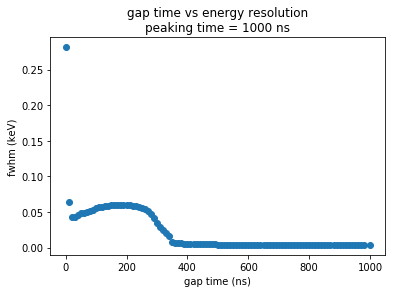

In [78]:
plt.plot(m_values_ns, fwhm_percent, 'o')
print(m_values_ns[0:20])
plt.xlabel('gap time (ns)')
plt.ylabel('fwhm (keV)')
plt.savefig('gap_optimization.png')
plt.title('gap time vs energy resolution' + '\n'  + 'peaking time = 1000 ns')
plt.show()

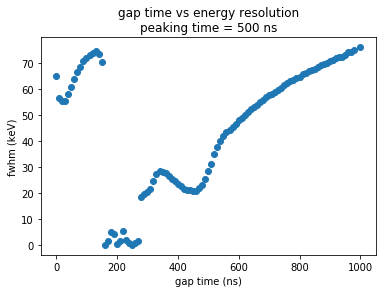

In [69]:
plt.plot(m_values_ns, fwhm_values, 'o')
plt.xlabel('gap time (ns)')
plt.ylabel('fwhm (keV)')
plt.savefig('gap_optimization.png')
plt.title('gap time vs energy resolution' + '\n'  + 'peaking time = 500 ns')
plt.show()

In [ ]:
plt.plot(bins, co_counts)
plt.show()
plt.plot(bins[200:400], co_counts[200:400])
plt.show()
plt.plot(bins[400:], co_counts[400:])
plt.show()

In [ ]:
plt.plot(m_values, index, 'o')
plt.show()

In [ ]:
plt.plot(m_values_ns, fwhm_values, 'o')
plt.show()

In [ ]:
plt.plot(m_values_ns, fwhm_values, 'o')
plt.xlabel('gap time (ns)')
plt.title('variable gap with peaking time = 1')
plt.show()

In [ ]:
# END HERE STOP 

In [ ]:
#k_values = np.linspace(500, 10000, 2) # steps in 100 ns from 1ns to 10us
m_values = np.linspace(0, 100000, 10) # steps in 100 ns from 1ns to 10us

M = 4400

k = 100
#m_values = np.linspace(1, 10000, 10)

fwhm_values = []
m_values_ns = []
index = []
for m in m_values:
    print(m)
    m_values_ns.append(m * 10)
    nrgs = []
    number_of_events = len(raw_data)
    assert number_of_events <= len(raw_data)

    for i in range(0, number_of_events, 1):
        signal = raw_data[i,:]
        nrg = filter_and_get_energy(signal, l, k, M)
        nrgs.append(round(nrg, 7))
        
    nbins = 2048
    co_counts, bin_edges = np.histogram(nrgs, bins=2048, range=[2.3e8, 2.9e8]) # WORKS
    bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    index.append(np.argmax(co_counts))
   # co_energies = calibrate_co_spectrum(nrgs)
    #fwhm, center = get_energy_resolution_co_1173(co_energies, co_counts)
  #  fwhm, center = get_energy_resolution_co_1332(co_energies, co_counts)
        
  #  fwhm_values.append(fwhm)
        

In [ ]:

if __name__ == "__main__":

    filename = './DATA_co60_2.h5'
    hf = tables.open_file(filename, "r")

    event_data = hf.root.EventData.read()
    raw_data = hf.root.RawData.read()
    hf.close()

    sampling_time = 10.0
    n_data = 4096
    x_values = np.linspace(0, n_data, n_data)
    print("XVAL" , len(x_values))

    k = 100 # peaking
    m = 100 # gap
    raw_signal = raw_data[2,:]
    print("RAW ", len(raw_signal))
    plt.plot(x_values, raw_signal)
    signal = baseline_correction(raw_signal)
    signal = trapezoidal_filter_2(signal, m, k)

    plt.figure(41)
    plt.cla()
    plt.clf()
    plt.plot(x_values, signal)
    plt.title('sample sig')
    plt.show()

    energy = get_energy_value(signal)
    print(energy)

    nrgs_2 = []
    number_of_events = len(raw_data)
    number_of_events = 1
    assert number_of_events < len(raw_data)
    k = 100 # peaking time
    l = 100 # gap

    for i in range(0, number_of_events, 1):
        gap = 100
        peak = 100
        signal = raw_data[i,:]
        signal = baseline_correction(signal)
        maxval = max(signal)
        signal = signal / maxval
        signal = trapezoidal_filter_2(signal, gap, peak)
        signal = signal / 424829.69
        print('gain = ', max(signal))
        nrg = get_energy_value(signal)
        #nrg = filter_and_get_energy(raw_data[i,:], gap, peak)
        nrgs_2.append(round(nrg, 7))



    plt.hist(nrgs_2, 500, log=True)
    plt.show()